# In-class work 1: Introduction to training neural networks

Okay, now that we've covered some data science basics, let's get a very baseline neural network training pipeline going. 

**Important:** Make sure this notebook is pointing toward your custom `conda` kernel (top right drop-down menu).

<a name='section_0'></a>
<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">0. Installing pytorch</h2>

In [1]:
%pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.0/888.0 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 22.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 KB 24.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 22.3 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 MB 3.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 4.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 15.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 28.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import wandb

In [4]:
### test that torch will work 

import torch

x = torch.rand(5, 3)
print(x)

tensor([[0.6583, 0.5009, 0.0853],
        [0.7557, 0.1053, 0.0557],
        [0.8957, 0.3628, 0.4457],
        [0.6732, 0.8757, 0.3368],
        [0.0952, 0.8667, 0.7061]])


Here's a full cell of imports. What's a good resolution we can use for plotting? Refer to the previous in-class notebook if you can't remember, and fill it in here:

In [5]:
### here's the full cell of imports 

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

### set plot resolution
%config InlineBackend.figure_format = 'retina' # <<<<<<<<<<<< INSERT CODE HERE

### set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title

<a name='section_1'></a>
<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">1. Generating a dataset</h2>

First, we'll generate one of the simplest toy datasets there is: two Gaussian distributions. Let's say that they describe our signal and our background events, but that there are only 2 parameters we can measure ($\theta_1$ and $\theta_2$).

In [6]:
### Two 2D Gaussian distributions with the same number of events
n_events = 2000

### Background is sampled from N(mu0, Sigma0)
mu0 = np.array([-1.0, -1.0])
cov0 = np.array([[1.0, 0.2],
                 [0.2, 1.2]])
x0 = np.random.multivariate_normal(mu0, cov0, size=n_events)
y0 = np.zeros((n_events, 1), dtype=np.float32)

### Signal is sampled from N(mu1, Sigma1)
mu1 = np.array([1.0, 1.0])
cov1 = np.array([[1.3, -0.3],
                 [-0.3, 0.8]])
x1 = np.random.multivariate_normal(mu1, cov1, size=n_events)
y1 = np.ones((n_events, 1), dtype=np.float32)

X = np.vstack([x0, x1]).astype(np.float32)
y = np.vstack([y0, y1]).astype(np.float32)

### Put these together and shuffle
idx = np.random.permutation(len(X))
X = X[idx] # inputs
y = y[idx] # labels

print("Data shapes:", X.shape, y.shape)

Data shapes: (4000, 2) (4000, 1)


Let's put it into a Pandas dataframe for legibility:

In [7]:
df = pd.DataFrame(np.hstack([X,y]), columns = ["theta_1", "theta_2", "label"])

In [8]:
df

,theta_1,theta_2,label
0,0.243788,1.425005,1.0
1,0.340708,0.001202,1.0
2,-1.712988,-3.167301,0.0
3,-1.744001,-0.176957,0.0
4,-0.113941,0.386218,1.0
...,...,...,...
3995,1.784824,0.902250,1.0
3996,-1.861259,-0.495096,0.0
3997,-1.687814,-2.814842,0.0
3998,0.355250,0.890255,1.0


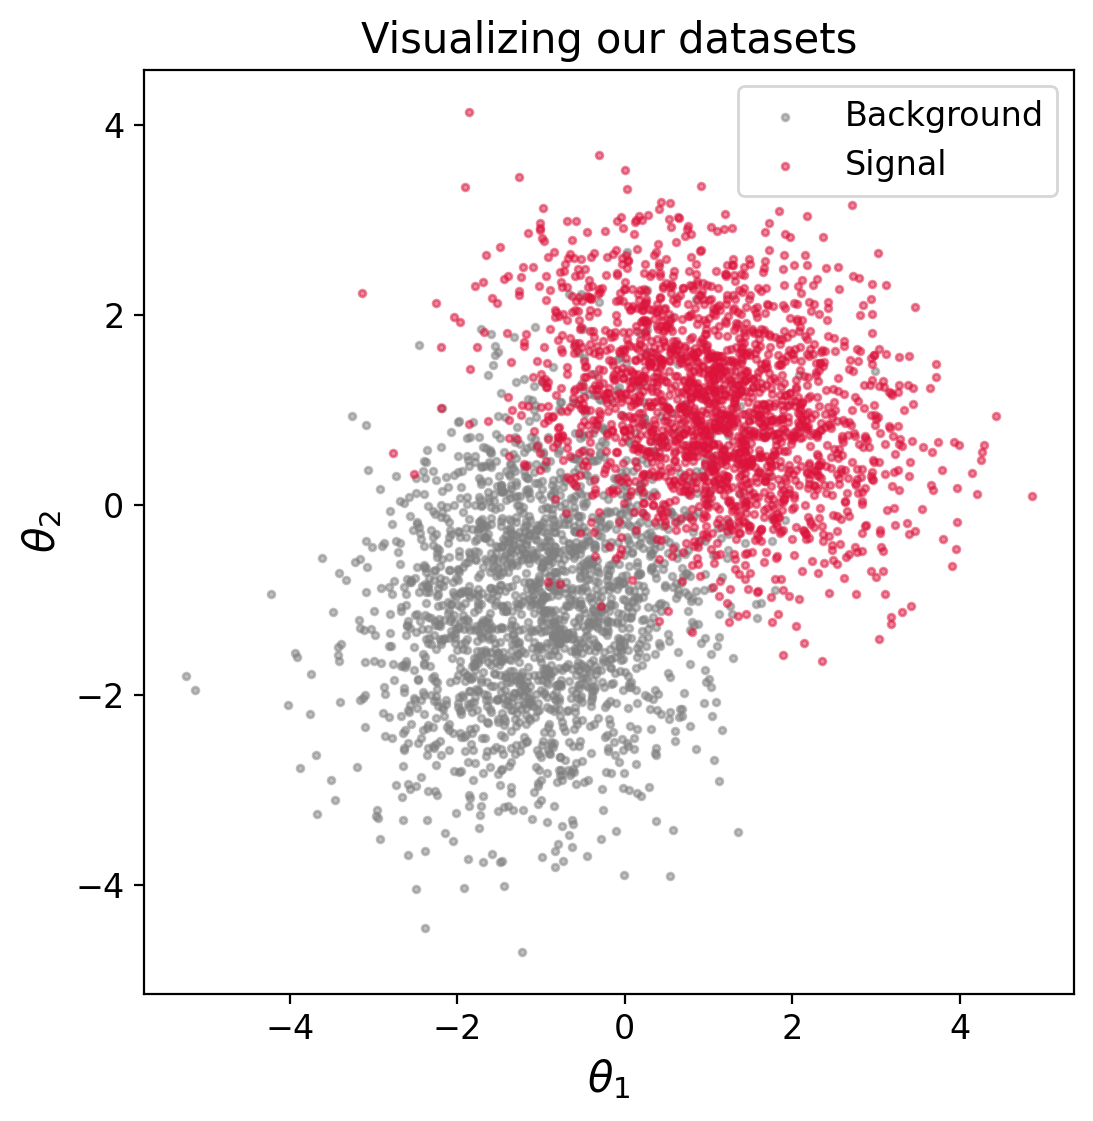

In [9]:
plt.figure(figsize=(6,6))
plt.scatter(df[df.label != True].theta_1, df[df.label != True].theta_2, s=6, color="grey", alpha=0.5, label="Background")
plt.scatter(df[df.label == True].theta_1, df[df.label == True].theta_2, s=6, color="crimson", alpha=0.5, label="Signal")
plt.legend()
plt.title("Visualizing our datasets")
plt.xlabel(r"$\theta_1$"); plt.ylabel(r"$\theta_2$")
plt.show()

<a name='section_2'></a>
<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">2. Defining a neural network model</h2>

In [10]:
class MLP(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32): # <<<< FILL IN INPUT DIMENSION 
        super().__init__()
        self.MLP = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # output is 1-dimensional for binary classification
        )
    def forward(self, x):
        return self.MLP(x)

<a name='section_3'></a>
<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">3. Preprocessing</h2>

Key steps include splitting into train/validation/test sets, standardizing data, and building dataloaders.

In [11]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["label"])  # only look at the features, not the labels
y = df["label"]                 # labels

### Take the first 70% for training
X_train, X_valtest, y_train, y_valtest = train_test_split(
    X, y, test_size=0.3)

### Then evenly split the remaining 30% into validation & test set 
X_val, X_test, y_val, y_test = train_test_split(
    X_valtest, y_valtest, test_size=0.5
)

print(f"Train set has {len(X_train)} events.")
print(f"Validation set has {len(X_val)} events.")
print(f"Test set has {len(X_test)} events.")

Train set has 2800 events.
Validation set has 600 events.
Test set has 600 events.


You can standardize your data using a "z-score" manually by subtracting the mean and dividing by the standard deviation. 

$$
z_{score} = data - \mu / \sigma
$$

Alternatively, you can use the StandardScaler plugin to do this automatically:

In [12]:
from sklearn.preprocessing import StandardScaler

### initialize the scaler
scaler = StandardScaler()

### IMPORTANT -- you only want to define your scaling ("fit_transform") based on your training dataset.
X_train_scaled = scaler.fit_transform(X_train)

### Now re-use the same transformation on validation & test sets ("transform")
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Train mean (before scaling):", np.array(X_train.mean(axis=0)))
print("Train mean (after scaling) -- each dimension should be close to 0:", X_train_scaled.mean(axis=0))
print("Train std (before scaling)", np.array(X_train.std(axis=0)))
print("Train std (after scaling) -- each dimension should be close to 1:", X_train_scaled.std(axis=0))

Train mean (before scaling): [0.02952274 0.00311412]
Train mean (after scaling) -- each dimension should be close to 0: [ 3.2888992e-09 -3.2995429e-10]
Train std (before scaling) [1.4730989 1.418146 ]
Train std (after scaling) -- each dimension should be close to 1: [0.9999997 0.9999995]


<a name='problem_x'></a> 
### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #1f77b4; color: #1f77b4;">Problem: Standardizing with z-scores </span>

Try implementing this standardization by hand, and check that your scaled distributions are close to the ones that you got using the StandardScaler.

In [20]:
X_train

,theta_1,theta_2
3363,0.111882,-0.402004
3164,-1.033193,-0.450375
2504,1.698980,1.858232
3947,0.378012,2.988938
3765,2.550686,0.690444
...,...,...
2148,-0.124128,-1.986001
3905,-0.069295,1.176186
2894,1.579625,0.741409
1757,0.641971,3.243241


In [29]:
xT_0 = np.mean(X_train['theta_1'])
xSTD_0 = np.std(X_train['theta_1'])
xT_1 = np.mean(X_train['theta_2'])
xSTD_1 = np.std(X_train['theta_2'])
z_score_0 = (X_train['theta_1'] - xT_0) / xSTD_0
z_score_1 = (X_train['theta_2'] - xT_1) / xSTD_1

In [31]:
X_train_scaled

array([[ 0.08430303, -0.27738872],
       [-0.7015757 , -0.31139967],
       [ 1.1735473 ,  1.3118175 ],
       ...,
       [ 1.0916327 ,  0.5265623 ],
       [ 0.44810924,  2.2856383 ],
       [ 0.16545346,  1.1012716 ]], dtype=float32)

In [40]:
np.array([z_score_0, z_score_1]).transpose()

array([[ 0.08430302, -0.2773887 ],
       [-0.70157564, -0.31139967],
       [ 1.1735471 ,  1.3118175 ],
       ...,
       [ 1.0916327 ,  0.5265623 ],
       [ 0.44810924,  2.2856383 ],
       [ 0.16545345,  1.1012716 ]], dtype=float32)

In [41]:
X_train_scaled_by_hand = np.array([z_score_0, z_score_1]).transpose()
# X_val_scaled_by_hand = ??? 
# X_test_scaled_by_hand = ??? 

In [45]:
X_train_scaled[0]

array([ 0.08430303, -0.27738872], dtype=float32)

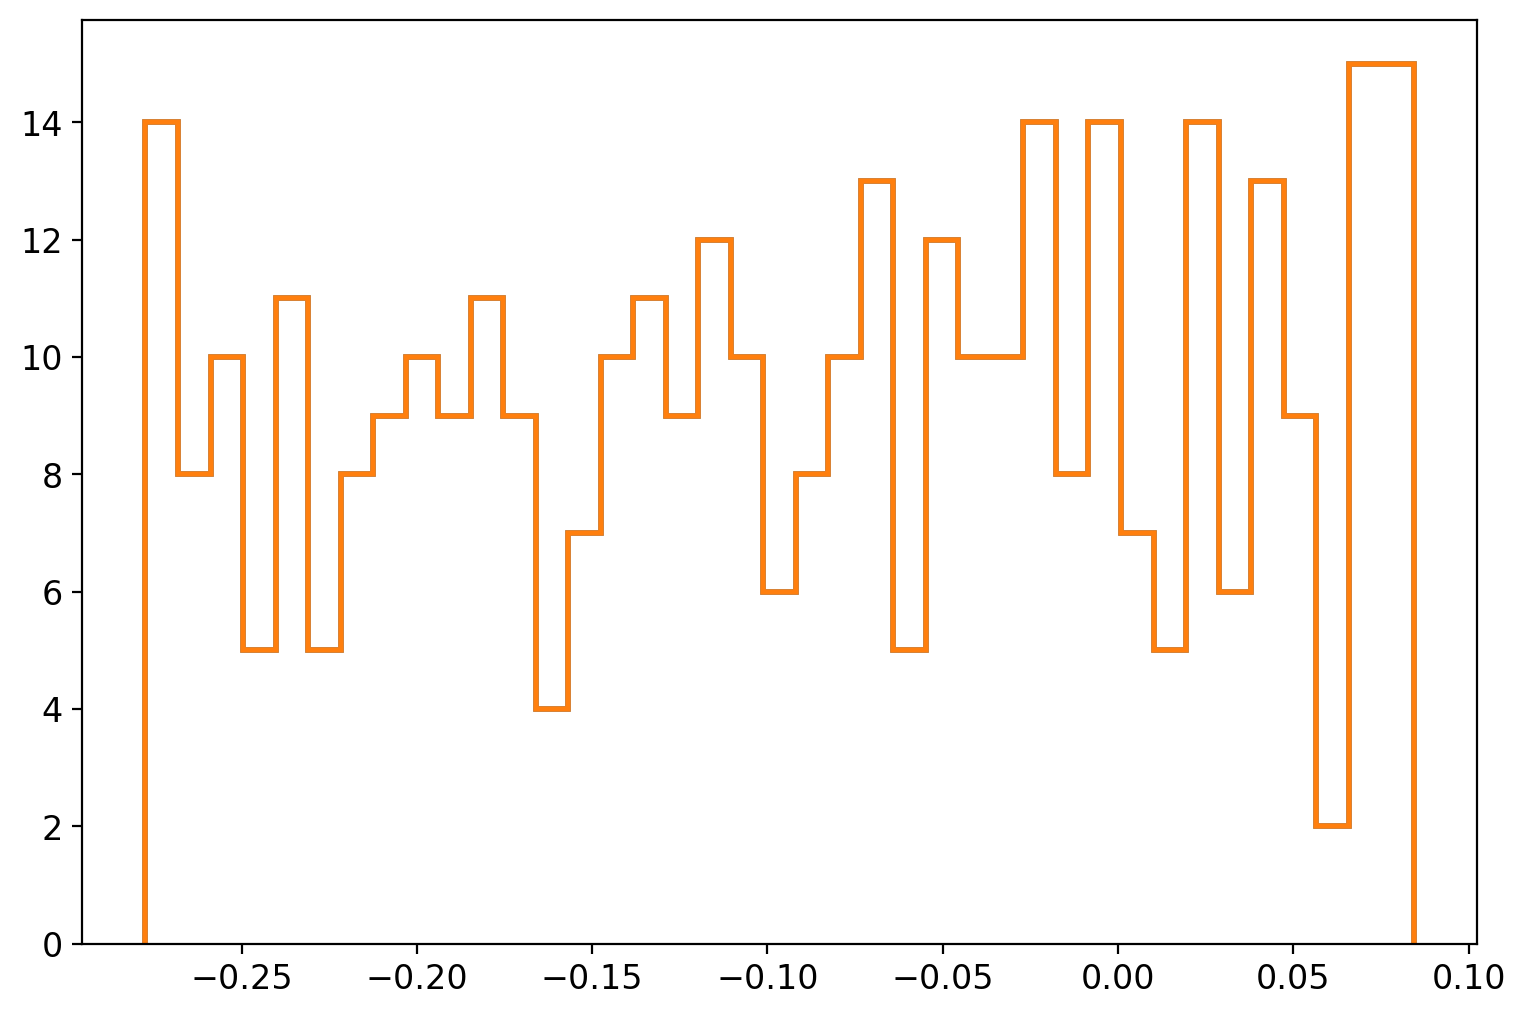

In [47]:
plt.figure()
bins = np.linspace(np.min(X_train_scaled[0]), np.max(X_train_scaled[0]) , 40)
### theta_1
plt.hist(X_train_scaled[:,0], bins=bins, histtype="step", linewidth=2, label="$\theta_1$");
plt.hist(X_train_scaled_by_hand[:,0], bins=bins, histtype="step", linewidth=2, label="$\theta_1$ (by hand)");

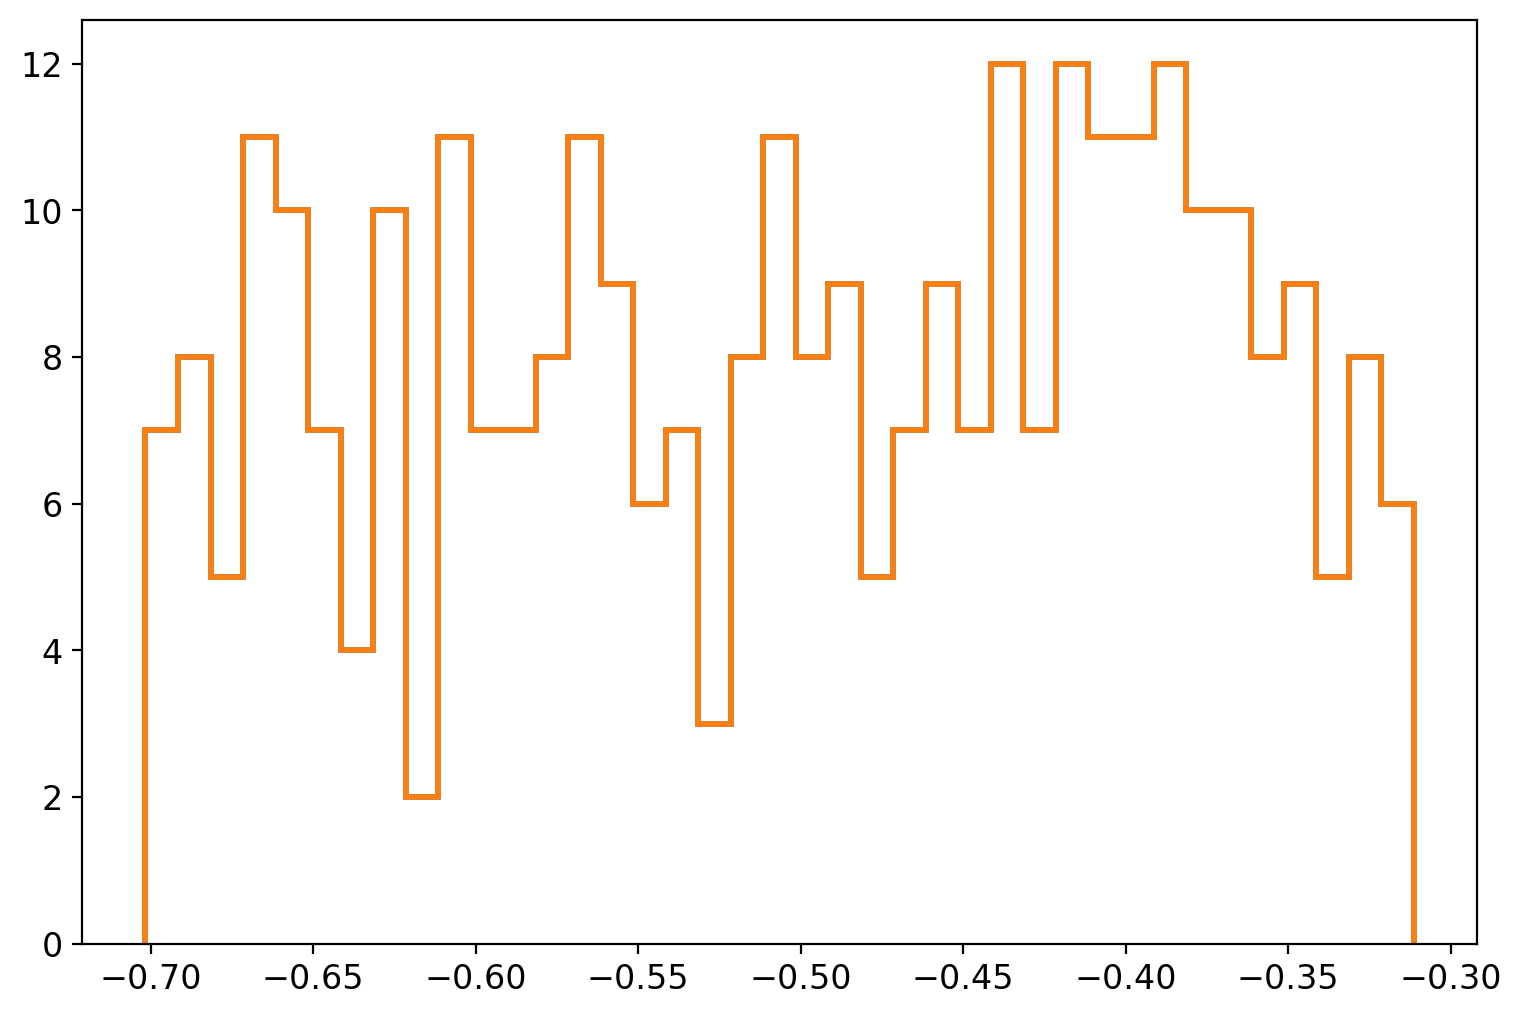

In [49]:
plt.figure()
bins = np.linspace(np.min(X_train_scaled[1]), np.max(X_train_scaled[1]), 40)
### theta_2
plt.hist(X_train_scaled[:,1], bins=bins, histtype="step", linewidth=2, label="$\theta_2$");
plt.hist(X_train_scaled_by_hand[:,1], bins=bins, histtype="step", linewidth=2, label="$\theta_2$ (by hand)");

In [13]:
### now we'll construct data loaders. we'll use 32 as our default batch size for now. 

batch_size = 32

train_ds = TensorDataset(torch.from_numpy(X_train_scaled), torch.from_numpy(y_train.values.astype("float32")).view(-1, 1))
val_ds   = TensorDataset(torch.from_numpy(X_val_scaled),   torch.from_numpy(y_val.values.astype("float32")).view(-1, 1))
test_ds  = TensorDataset(torch.from_numpy(X_test_scaled),  torch.from_numpy(y_test.values.astype("float32")).view(-1, 1))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

Test one of these loaders:

In [14]:
for x_batch, y_batch in train_loader:
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 2]) torch.Size([32, 1])


<a name='section_4'></a>
<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">4. Training</h2>

Let's play with tracking our model training using `livelossplot`.

In [15]:
%pip install livelossplot

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 14.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.3/407.3 KB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 19.3 MB/s eta 0:00:00
  Attempting uninstall: contourpy
    Found existing installation: contourpy 1.0.7
    Uninstalling contourpy-1.0.7:
      Successfully uninstalled contourpy-1.0.7
Note: you may need to restart the kernel to use updated packages.


In [16]:
from livelossplot import PlotLosses

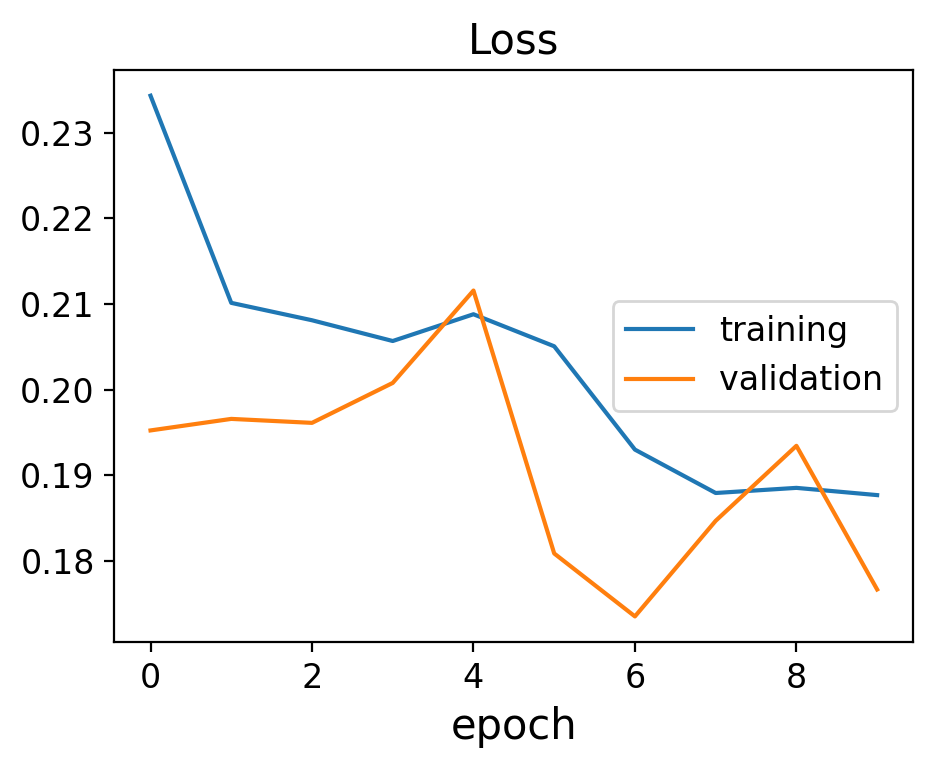

Loss
	training         	 (min:    0.188, max:    0.234, cur:    0.188)
	validation       	 (min:    0.174, max:    0.212, cur:    0.177)
Epoch 9, Loss: 0.1286076307296753


In [18]:
### Check for available GPUs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

### Initialize the model, optimizer, and loss function -- what should the input dimensionality be?
model = MLP(input_dim=2, hidden_dim=32).to(device) #<<<<<<<< FILL IN HERE
model = model.to(device) # move onto the GPU, if present
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.2 ) #<<<<<<<< FILL IN HERE -- what's the default learning rate for Adam?

liveloss = PlotLosses(figsize=(9, 4)) 
logs = {}

### Training loop
for epoch in range(10):

    ### train
    model.train()
    total_train_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        ### Move the batch onto the GPU, if present
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        out = model(x_batch)
        loss = loss_fn(out, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    train_loss_per_batch = total_train_loss / len(train_loader)
    logs['loss'] = train_loss_per_batch

    ### validate
    model.eval()
    total_val_loss = 0
    for x_batch, y_batch in val_loader:
        
        ### Move the batch onto the GPU, if present
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        out = model(x_batch)
        loss = loss_fn(out, y_batch)
        total_val_loss += loss.item()
    
    val_loss_per_batch = total_val_loss / len(val_loader)
    logs['val_loss'] = val_loss_per_batch
    
    liveloss.update(logs)
    
    liveloss.send()
    print(f'Epoch {epoch}, Loss: {loss.item()}')

#### Using wandb

Skip this for now, but if you have time once you finish this notebook, try connecting the notebook to Wandb to have the option of tracking your runs: 
- https://docs.wandb.ai/guides/track/jupyter/ 

In [ ]:
# %pip install wandb -qqq

In [19]:
import wandb


In [20]:
wandb.init(
project="Intro to NN", 
config = {
    "learning_rate": 0.02, 
    "architecture": "CNN",

    },
)

wandb: Currently logged in as: alicia-mand (alicia-mand-uw-madison) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
wandb.log({"acc": acc})

<a name='section_5'></a>
<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">5. Evaluating model performance</h2>

The loss alone might not be a very intuitive metric for understanding our model performance. Let's evaluate the model on our holdout test set and get some new metrics.

In [ ]:
### set the threshold for your NN score (what value makes sense here? can you plot values of your NN scores to understand their distribution?) 
threshold = ??? # <<<< FILL IN HERE

### test set 
model.eval()
test_loss, test_acc, count = 0.0, 0.0, 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        
        ### Move the batch onto the GPU, if present
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
    
        out = model(x_batch)
        loss = loss_fn(out, y_batch)
        test_loss += loss.item() * x_batch.size(0)
        test_acc  += (torch.sigmoid(out) > threshold).float().eq(y_batch).float().mean().item() * x_batch.size(0)
        count += x_batch.size(0)
        
print(f"Average test loss: {test_loss/count:.4f} | Test accuracy: {test_acc/count:.3f}")

### Further exercises:
- Try modifying the hidden size and number of MLP layers, to see the effect on performance
- Try increasing the dataset size
- Try different learning rates
- What's the effect of changing your batch size?
- Try adding dropout
- Try making the task harder by making the Gaussians overlap and/or shifting their positions. Where does your model start to break down?
- Can you track an "accuracy" metric alongside the loss in your live tracking plots?
- Can you track your runs on Wandb? 
- What is a simple baseline you could define here to get context for how well your model is doing? Implement this and use it as a comparison.
- Can you visualize the decision boundary in parameter space?